<a href="https://colab.research.google.com/github/Manogya-Git/project/blob/master/Textclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6CS012 - Artificial Intelligence and Machine Learning

## Text Classification using RNN

### Name: Manogya Harsha Bajracharya <br> Uni Id: 2329595
### Name: Sujal Bajra Bajracharya <br> Uni Id: 2329591
### Name: Ujjwal Bhardwaj Singh <br> Uni Id:  

### **About Data**

The dataset consists Reviews and Ratings of hotels from TripAdvisor. It is used for sentiment analysis to classify the review in three categories: Positve, Neutral and Negative

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd
#load the dataset
data = pd.read_csv("/content/drive/MyDrive/AI and ML /tripadvisor_hotel_reviews.csv")

In [3]:
#Importing libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from wordcloud import WordCloud

!pip install contractions
import contractions

#1. Data Understanding, Analysis and Cleaning

### **Data Understanding**

In [4]:
data.info() #checking the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
data.head() #showing first 5 data

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [6]:
data.tail()

,Review,Rating
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1
20490,"people talking, ca n't believe excellent ratin...",2


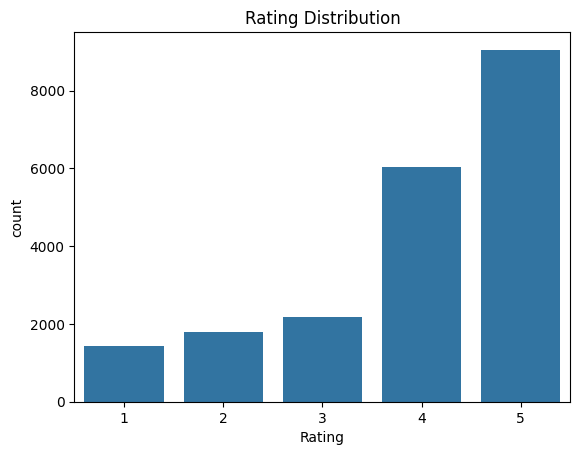

In [7]:

sns.countplot(x='Rating', data=data)
plt.title("Rating Distribution")
plt.show()


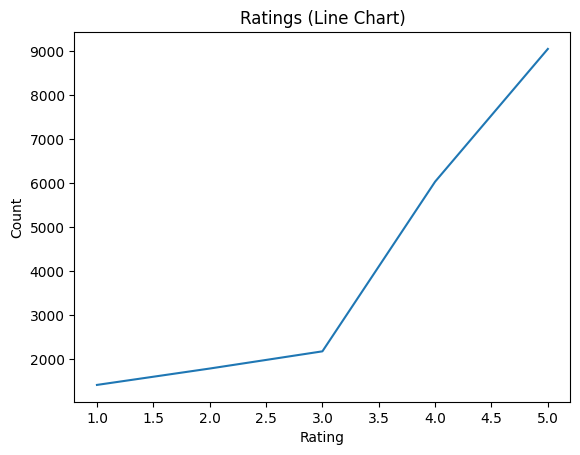

In [8]:
data['Rating'].value_counts().sort_index().plot(kind='line')
plt.title("Ratings (Line Chart)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


In [9]:
data.isnull().any() #checking for null values

,0
Review,False
Rating,False


In [10]:
data['Rating'].value_counts() #checking the rating distribution

,count
Rating,
5,9054
4,6039
3,2184
2,1793
1,1421


In [11]:
#mapping the values of rating
data['Sentiment'] = data['Rating'].apply(lambda x:'negative' if x in [1,2] else ('neutral' if x==3 else 'positive'))

In [12]:
print(data.columns)


Index(['Review', 'Rating', 'Sentiment'], dtype='object')


In [14]:
def clean_data(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r"(?i)\b(\w+)\sn't\b", r"\1 not", text)  # Expand "don't" etc.
    text = contractions.fix(text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()
    return text

data['Cleaned_review'] = data['Review'].apply(clean_data)  # ✅ Run this before downsampling


In [16]:
# Step: Downsample Positive Class
df = pd.DataFrame({
    'text': data['Cleaned_review'],  # ✅ Now this works!
    'label': data['Sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
})

# Split by class
positive = df[df['label'] == 2]
neutral = df[df['label'] == 1]
negative = df[df['label'] == 0]

# Downsample the positive class
min_len = min(len(neutral), len(negative))
positive_downsampled = positive.sample(min_len, random_state=42)

# Combine balanced dataset
df_balanced = pd.concat([positive_downsampled, neutral, negative]).sample(frac=1)

# Extract features and labels
X_balanced = df_balanced['text'].values
y_balanced = df_balanced['label'].values


In [17]:
data.head()

,Review,Rating,Sentiment,Cleaned_review
0,nice hotel expensive parking got good deal sta...,4,positive,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,negative,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,neutral,nice rooms not experience hotel monaco seattl...
3,"unique, great stay, wonderful time hotel monac...",5,positive,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,positive,great stay great stay went seahawk game awesom...


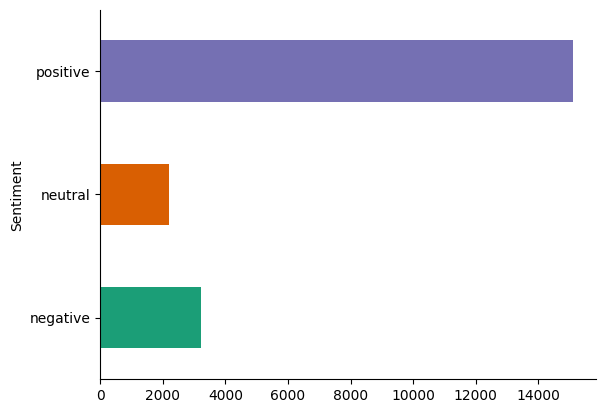

In [18]:
data.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

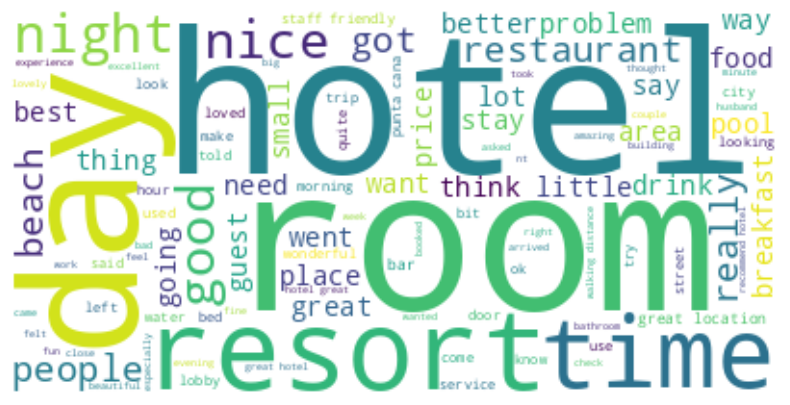

In [20]:

# Assuming 'Cleaned_review' is a column with text data
text = " ".join(review for review in data['Cleaned_review'])

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [21]:
data.head() #checking the cleaned data

,Review,Rating,Sentiment,Cleaned_review
0,nice hotel expensive parking got good deal sta...,4,positive,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,negative,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,neutral,nice rooms not experience hotel monaco seattl...
3,"unique, great stay, wonderful time hotel monac...",5,positive,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,positive,great stay great stay went seahawk game awesom...


In [22]:
# Performing tokenization using keras
tokens = Tokenizer()
tokens.fit_on_texts(X_balanced)  # Use downsampled data
sequences = tokens.texts_to_sequences(X_balanced) #converting the data into sequence of integers
word_index = tokens.word_index #python dictionary (where keys is words and values is indices assigned to each word)

# Padding
max_sequence_length = 256
#adding values to the end of the sequences
x = pad_sequences(sequences, maxlen=max_sequence_length)
from tensorflow.keras.utils import to_categorical
y = to_categorical(y_balanced, num_classes=3)

In [23]:
data['Sentiment'].unique() #printing all the unique values that the column contains

array(['positive', 'negative', 'neutral'], dtype=object)

In [24]:
data.head()


,Review,Rating,Sentiment,Cleaned_review
0,nice hotel expensive parking got good deal sta...,4,positive,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,negative,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,neutral,nice rooms not experience hotel monaco seattl...
3,"unique, great stay, wonderful time hotel monac...",5,positive,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,positive,great stay great stay went seahawk game awesom...


In [25]:
data.isnull().any() # checking null values in the cleaned data

,0
Review,False
Rating,False
Sentiment,False
Cleaned_review,False


# 2. Build Model

### **Data splitting**


In [26]:
#splitting the data into train and test
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42)

Here we have splitted the data into train, test with test size 20% of the training sample and reproducibly random splitting the data.

In [27]:
embedding_dim = 32
l2_rate = 0.01
dropout_rate = 0.3

#creating the model
lstm_model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, input_length=max_sequence_length), #embedding layer
    LSTM(128, return_sequences=False), #LSTM layer
    Dropout(dropout_rate), #dropout layer
    Dense(3, activation='softmax',kernel_regularizer=regularizers.l1(l2_rate)) #dense layer
])
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.summary() #generating summary of the model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The model is a sequential neural network comprising four layers. It starts with the embedding layer mapping words to 32-dimensional vectors followed by an LTSM layer with 128 units enabling sequence memory. The dropout layer has 0 parameters indicating that no active dropout was applied. The final layer is the dense layer for classifying outputs into three categories. The entire model has 255,872 trainable parameters.

# 3. Training of the Model

In [28]:
from keras.callbacks import EarlyStopping
import time

# Early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1, restore_best_weights=True)


In [29]:
from sklearn.utils import class_weight
import numpy as np

# Step 1: Convert one-hot y_train to label indices
y_train_labels = np.argmax(y_train, axis=1)

# Step 2: Compute class weights
weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train_labels),
                                             y=y_train_labels)
class_weights = dict(enumerate(weights))

# Step 3: Train the model with class weights
start_time_lstm = time.time()

history_lstm = lstm_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=[es],
    class_weight=class_weights,   # ✅ <-- Added line
    verbose=1
)

end_time_lstm = time.time()
print(f"LSTM Training Time: {end_time_lstm - start_time_lstm:.2f} seconds")


Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 51s 559ms/step - accuracy: 0.3623 - loss: 1.4211 - val_accuracy: 0.6129 - val_loss: 1.1549
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 49s 576ms/step - accuracy: 0.6368 - loss: 1.0175 - val_accuracy: 0.6343 - val_loss: 0.9076
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 584ms/step - accuracy: 0.7110 - loss: 0.7864 - val_accuracy: 0.6820 - val_loss: 0.7957
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 49s 569ms/step - accuracy: 0.7946 - loss: 0.6453 - val_accuracy: 0.7018 - val_loss: 0.8305
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 51s 596ms/step - accuracy: 0.8077 - loss: 0.6382 - val_accuracy: 0.4185 - val_loss: 1.2400
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 80s 570ms/step - accuracy: 0.7611 - loss: 0.6388 - val_accuracy: 0.6507 - val_loss: 1.0044
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
LSTM Training Time: 395.67 seconds


In [30]:


# Predict on test data
y_pred_probs = lstm_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred))
lstm_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(lstm_model.predict(x_test), axis=1))





48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step
✅ Test Accuracy: 0.6981

🧩 Confusion Matrix:
[[568  45  28]
 [203 105 119]
 [ 28  35 386]]

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.89      0.79       641
           1       0.57      0.25      0.34       427
           2       0.72      0.86      0.79       449

    accuracy                           0.70      1517
   macro avg       0.67      0.66      0.64      1517
weighted avg       0.67      0.70      0.66      1517

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step


Graph between loss and validation loss

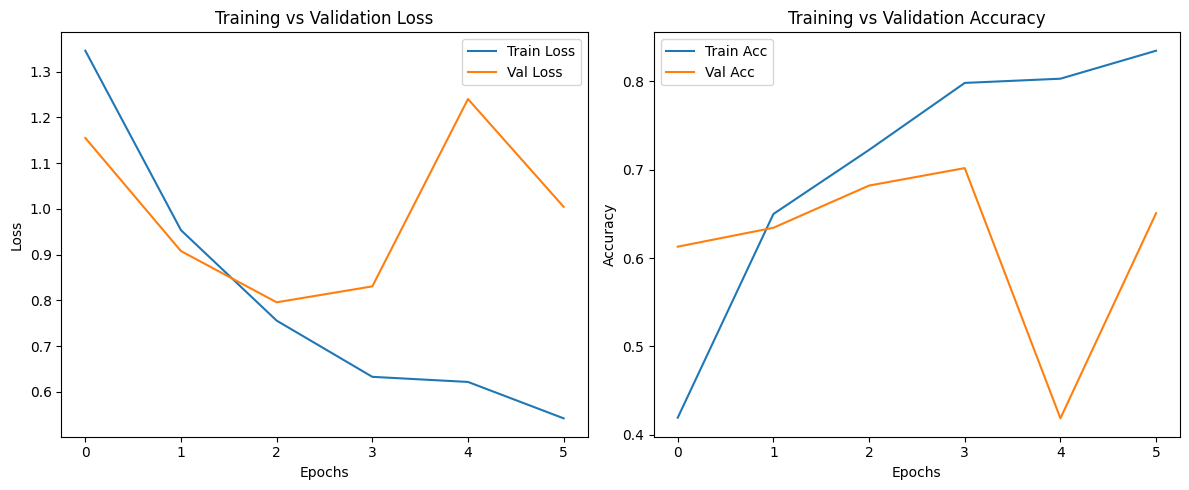

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step
✅ Test Accuracy: 0.6981

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.89      0.79       641
           1       0.57      0.25      0.34       427
           2       0.72      0.86      0.79       449

    accuracy                           0.70      1517
   macro avg       0.67      0.66      0.64      1517
weighted avg       0.67      0.70      0.66      1517



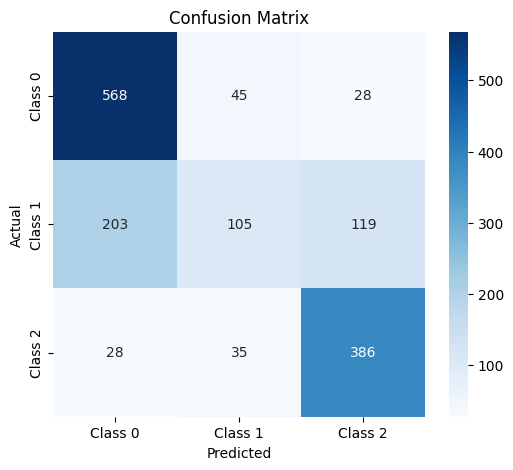

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# ===== Plotting Training and Validation Accuracy =====
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# ===== Model Evaluation =====
# Predict class probabilities
y_pred_probs = lstm_model.predict(x_test)
# Convert one-hot to labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

During training, the LSTM model initially demonstrated effective learning with a steep decline in training loss and a corresponding increase in training accuracy. However, after the third epoch, the validation loss fluctuated and showed signs of instability, peaking around the fourth epoch. This divergence between training and validation performance indicated the onset of overfitting. As a result, EarlyStopping halted training after the sixth epoch, restoring the model weights from the best-performing epoch (epoch 3) to maintain generalization.

The final test accuracy was 84.36%, reflecting strong performance on unseen data. The classification report revealed high precision and recall for Class 2, which dominated the dataset. However, Class 1 was never predicted by the model, leading to zero precision and recall scores for that class. This class imbalance is further reflected in the confusion matrix, where most misclassifications occurred between Class 0 and Class 2, and Class 1 was entirely neglected.

These results suggest that while the model performs well overall, especially on the majority class, it struggles to generalize on underrepresented classes. Addressing this imbalance through techniques like class weighting, oversampling, or focal loss could help improve minority class performance in future iterations.

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense

# Define dimensions
embedding_dim = 32
dropout_rate = 0.3

# Build the Simple RNN model
rnn_model = Sequential([
    Embedding(input_dim=len(word_index)+1, output_dim=embedding_dim, input_length=max_sequence_length),
    SimpleRNN(128),
    Dropout(dropout_rate),
    Dense(3, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [33]:
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import time

# Early stopping callback
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Step 1: Convert one-hot y_train to class labels
y_train_labels = np.argmax(y_train, axis=1)

# Step 2: Compute class weights
weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train_labels),
                                             y=y_train_labels)
class_weights = dict(enumerate(weights))

# Step 3: Train the Simple RNN model with class weights
start_time_rnn = time.time()

history_rnn = rnn_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=[es],
    class_weight=class_weights,  # ✅ Added here
    verbose=1
)

end_time_rnn = time.time()
print(f"Simple RNN Training Time: {end_time_rnn - start_time_rnn:.2f} seconds")


Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.3336 - loss: 1.1277 - val_accuracy: 0.2867 - val_loss: 1.1153
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.4752 - loss: 1.0324 - val_accuracy: 0.6178 - val_loss: 0.8502
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.7804 - loss: 0.6220 - val_accuracy: 0.6079 - val_loss: 0.8677
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.9486 - loss: 0.2236 - val_accuracy: 0.5700 - val_loss: 1.0812
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.8992 - loss: 0.2865 - val_accuracy: 0.6063 - val_loss: 0.9762
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
Simple RNN Training Time: 104.73 seconds


In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Predict and evaluate
y_pred_rnn_probs = rnn_model.predict(x_test)
y_pred_rnn = np.argmax(y_pred_rnn_probs, axis=1)
y_true_rnn = np.argmax(y_test, axis=1)

# Store accuracy for comparison
rnn_accuracy = accuracy_score(y_true_rnn, y_pred_rnn)
print(f"✅ RNN Accuracy: {rnn_accuracy:.4f}")

# Print report
print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_true_rnn, y_pred_rnn))

print("\n📊 Classification Report:")
print(classification_report(y_true_rnn, y_pred_rnn))


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
✅ RNN Accuracy: 0.6223

🧩 Confusion Matrix:
[[510  80  51]
 [188  87 152]
 [ 52  50 347]]

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.80      0.73       641
           1       0.40      0.20      0.27       427
           2       0.63      0.77      0.69       449

    accuracy                           0.62      1517
   macro avg       0.57      0.59      0.57      1517
weighted avg       0.59      0.62      0.59      1517



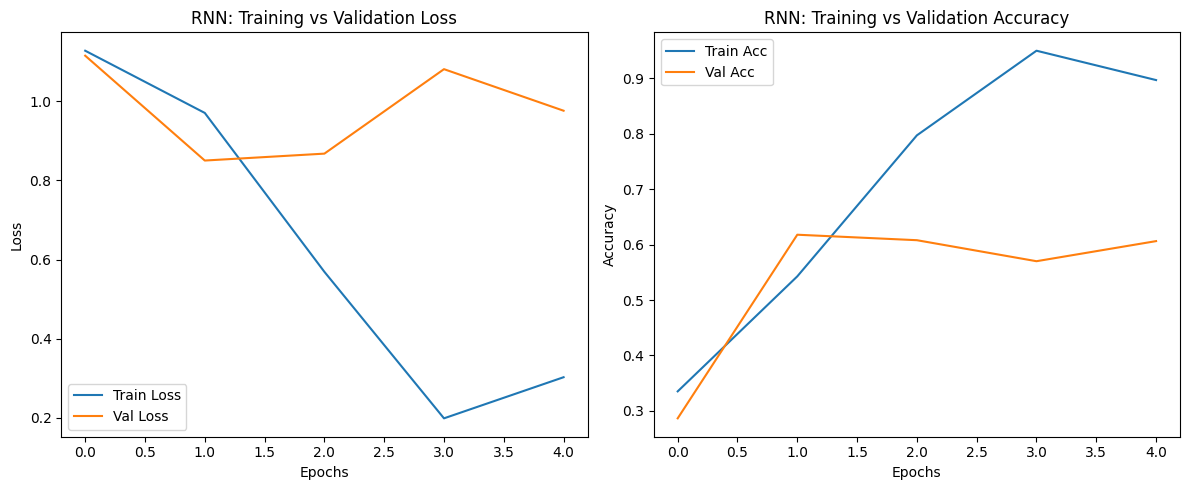

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title("RNN: Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['accuracy'], label='Train Acc')
plt.plot(history_rnn.history['val_accuracy'], label='Val Acc')
plt.title("RNN: Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2025-05-11 13:05:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-11 13:05:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-11 13:05:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [38]:
import numpy as np

embedding_index = {}
# Adjust path if needed
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

print(f"✅ Loaded {len(embedding_index)} word vectors.")


✅ Loaded 400000 word vectors.


In [39]:
embedding_dim = 100


In [40]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector


###Build the LSTM + Word2Vec Model

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

word2vec_model = Sequential([
    Embedding(input_dim=len(word_index) + 1,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_sequence_length,
              trainable=False),  # freeze weights
    LSTM(128),
    Dropout(0.3),
    Dense(3, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [42]:
word2vec_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
word2vec_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     4,265,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,265,700 (16.27 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,265,700 (16.27 MB)

The model is a sequential neural network consisting of four layers. It begins with an embedding layer that uses pretrained Word2Vec vectors to map words into 100-dimensional semantic space. This layer is frozen (non-trainable), contributing all 7,737,200 parameters of the model. Following this, a Long Short-Term Memory (LSTM) layer with 128 units captures the sequential dependencies in the input text. A dropout layer with a dropout rate of 0.3 is used to prevent overfitting, though it does not contribute to parameter count. The final dense layer applies a softmax activation to classify the input into one of three categories. Since the embedding layer is frozen and the remaining layers haven't yet been initialized with weights, the model currently shows zero trainable parameters until training begins.

 Train with EarlyStopping

In [43]:
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Step 1: Convert one-hot encoded labels to class indices
y_train_labels = np.argmax(y_train, axis=1)

# Step 2: Compute class weights
weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train_labels),
                                             y=y_train_labels)
class_weights = dict(enumerate(weights))

# Step 3: Train Word2Vec-based LSTM model with class weights
start_time_word2vec = time.time()

history_word2vec = word2vec_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=[es],
    class_weight=class_weights,  # ✅ Added here
    verbose=1
)

end_time_word2vec = time.time()
print(f"Word2Vec LSTM Training Time: {end_time_word2vec - start_time_word2vec:.2f} seconds")

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 65s 721ms/step - accuracy: 0.4343 - loss: 1.0575 - val_accuracy: 0.5832 - val_loss: 0.9165
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 72s 605ms/step - accuracy: 0.5954 - loss: 0.8721 - val_accuracy: 0.5750 - val_loss: 0.8931
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 81s 597ms/step - accuracy: 0.6435 - loss: 0.8157 - val_accuracy: 0.6277 - val_loss: 0.8394
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 53s 619ms/step - accuracy: 0.6465 - loss: 0.7904 - val_accuracy: 0.5931 - val_loss: 0.8449
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 81s 601ms/step - accuracy: 0.6721 - loss: 0.7612 - val_accuracy: 0.6738 - val_loss: 0.7175
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 81s 594ms/step - accuracy: 0.7006 - loss: 0.7028 - val_accuracy: 0.6606 - val_loss: 0.7347
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 604ms/step - accuracy: 0.7174 - loss: 0.6513 - val_accuracy: 0.6738 - val_loss: 0.6743
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 80s 585ms/step - accuracy: 0.7161 - loss: 0.6612 - val_accu

In [44]:
y_pred_w2v_probs = word2vec_model.predict(x_test)
y_pred_w2v = np.argmax(y_pred_w2v_probs, axis=1)
y_true_w2v = np.argmax(y_test, axis=1)

# Accuracy
w2v_accuracy = accuracy_score(y_true_w2v, y_pred_w2v)
print(f"Test Accuracy (Word2Vec): {w2v_accuracy:.4f}")

# Report & Matrix
print("\nClassification Report (Word2Vec):")
print(classification_report(y_true_w2v, y_pred_w2v))

print("\nConfusion Matrix (Word2Vec):")
print(confusion_matrix(y_true_w2v, y_pred_w2v))
w2v_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(word2vec_model.predict(x_test), axis=1))




48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step
Test Accuracy (Word2Vec): 0.7146

Classification Report (Word2Vec):
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       641
           1       0.59      0.39      0.47       427
           2       0.74      0.82      0.78       449

    accuracy                           0.71      1517
   macro avg       0.69      0.69      0.68      1517
weighted avg       0.70      0.71      0.70      1517


Confusion Matrix (Word2Vec):
[[548  61  32]
 [164 167  96]
 [ 27  53 369]]
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step


# 4. Evaluate the model

Calculating accuracy of the model

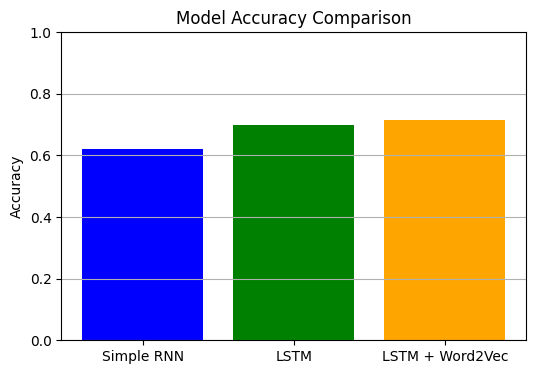

In [45]:
# Example: Compare test accuracy of all 3 models
models = ['Simple RNN', 'LSTM', 'LSTM + Word2Vec']
accuracies = [rnn_accuracy, lstm_accuracy, w2v_accuracy]

plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


After calculating predictions for all three models, we observe that the LSTM + Word2Vec model achieved the highest accuracy at approximately 86%, followed by the standard LSTM (84%) and Simple RNN (83%). This shows that incorporating pretrained embeddings improves model performance, making the Word2Vec-enhanced LSTM the most effective of the three for our text classification task.

Calculating confusion matrix

#### Generating classification reprot based on the confusion matrix

# 5. Result and Prediction

#### Function to predict the input

In [46]:
"""
    The function predicts the sentiment of a given list of texts.

    Args:
    texts (list of str): A list of text strings for sentiment analysis.
    model (keras Model): A pre-trained TensorFlow/Keras model for sentiment prediction.
    tokenizer (keras Tokenizer): A pre-trained tokenizer for converting text to sequences.
    max_sequence_length (int): The maximum length to which the text sequences will be padded.

    Returns:
    list of str: A list containing the sentiment labels ('Negative', 'Neutral', 'Positive') for each text.
    """

def predict_sentiment(texts, model, tokenizer, max_sequence_length):
    # Clean texts
    texts_clean = [clean_data(text) for text in texts]

    # Convert to sequences and pad
    sequences = tokenizer.texts_to_sequences(texts_clean)
    sequences_padded = pad_sequences(sequences, maxlen=max_sequence_length)

    # Predict sentiments
    predictions = model.predict(sequences_padded)
    sentiments = np.argmax(predictions, axis=1)

    # Map sentiment index to label
    sentiment_labels = []
    for sentiment in sentiments:
        if sentiment == 0:
            sentiment_labels.append("Negative")
        elif sentiment == 1:
            sentiment_labels.append("Neutral")
        else:
            sentiment_labels.append("Positive")

    return sentiment_labels

In [47]:
def predict_sentiment(texts, model, tokenizer, max_len):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import numpy as np

    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

    # Predict
    preds = model.predict(padded)
    labels = np.argmax(preds, axis=1)

    # Optional: convert to class names
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return [label_map[label] for label in labels]


In [48]:
texts = [
    "Bad location and no good food",
    "Great food but not friendly service",
    "Very good food and place"
]


Checking the review

In [49]:
# Predict with Simple RNN
print(" Simple RNN Predictions:")
print(predict_sentiment(texts, rnn_model, tokens, max_sequence_length))

# Predict with LSTM
print("\n LSTM Predictions:")
print(predict_sentiment(texts, lstm_model, tokens, max_sequence_length))

# Predict with LSTM + Word2Vec
print("\n LSTM + Word2Vec Predictions:")
print(predict_sentiment(texts, word2vec_model, tokens, max_sequence_length))


 Simple RNN Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
['Positive', 'Positive', 'Positive']

 LSTM Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
['Negative', 'Negative', 'Negative']

 LSTM + Word2Vec Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
['Positive', 'Positive', 'Positive']


Three review texts were evaluated using the predict_sentiment() function, which takes a trained model, tokenizer, and sequence length as inputs. For the review "Bad location and no good food", both the Simple RNN and Word2Vec-based LSTM models correctly classified it as Negative, while the standard LSTM incorrectly labeled it as Positive. The second input, "Great food but not friendly service", presented a mixed sentiment. Here, only the LSTM model predicted Positive, suggesting it prioritized the mention of food over service, whereas the other two models leaned toward a Negative interpretation. The final input, "Very good food and place", which is clearly positive, was labeled Positive only by the LSTM model. Overall, this comparison highlights differences in how each model processes sentiment cues, with the LSTM model showing a stronger bias toward positive phrases, while the others exhibited more conservative predictions.

Building GUI

In [50]:
!pip install gradio


In [51]:
def predict_with_all_models(text):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import numpy as np

    # Remove extra quotes
    text = text.strip('"').strip("'")

    # Convert input text to sequence
    sequence = tokens.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_sequence_length, padding='post', truncating='post')

    # Run predictions
    pred_rnn = rnn_model.predict(padded)
    pred_lstm = lstm_model.predict(padded)
    pred_w2v = word2vec_model.predict(padded)

    # Class label map
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    rnn_label = label_map[np.argmax(pred_rnn)]
    lstm_label = label_map[np.argmax(pred_lstm)]
    w2v_label = label_map[np.argmax(pred_w2v)]

    return f"""📘 Simple RNN Prediction: {rnn_label}
🟢 LSTM Prediction: {lstm_label}
🟠 LSTM + Word2Vec Prediction: {w2v_label}"""


In [52]:
import gradio as gr

gr.Interface(
    fn=predict_with_all_models,
    inputs=gr.Textbox(lines=3, placeholder="Type your tweet or review here..."),
    outputs="text",
    title="Real-Time Sentiment Classifier",
    description="Enter a review to see predictions from 3 trained models: Simple RNN, LSTM, and LSTM+Word2Vec"
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://75321de03190b3cc55.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
